# Important Papers

https://www.sciencedirect.com/science/article/pii/S0960077920303246?casa_token=g3PE29gmlPYAAAAA:Me4yIHdPkev1fSpsUuW0CkhVwXr4aH3cUHNkj__WwSZt6XGA1Nmk6wUEDMshkHyOCiLcwYY#sec0002

https://www.jstor.org/stable/4576118?seq=4

https://nzmj.org.nz/media/pages/journal/vol-131-no-1487/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years/ef4958102b-1696475878/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years.pdf

https://www.sciencedirect.com/science/article/pii/S1755436511000053

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
import numpy.typing as npt
from scipy.optimize import minimize
import numpy.typing as npt

In [243]:
import importlib
import SEIRD_model 
importlib.reload(SEIRD_model)

<module 'SEIRD_model' from '/home/gavin/Documents/NZ_data/SEIRD_model.py'>

# Generalized multi-population SEIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population group $g$ is stored in the Y matrix: $Y^{g}_{c}$, where $g$ is the population (stored in rows), and $c$ is the category ($S^g$, $E^g$, $I^g$, $R^g$ or $D^g$). Thus, in this case $Y$ is an $N$ by 5 matrix, where $N$ is the number of different populations. 

The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^i_g$, each element of which has the proportion of population group $g$ that spend that timestep in mixing environment $i$. It can also be thought of as the probability that a person from population $g$ will spend time in mixing environment $m$. $\sum_{m} \theta^m_g = 1$. 

$$ \sum_{g} \theta^m_g ~ Y^{g}_{c} = B^{m}_{c}, $$

where $B^m_c$ is an $M$ by 5 matrix of the number of people in mixing environment $m$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, exposed, infectious, recovered, or dead). 

The number of new infections in a particular group $g$ depends on their exposure to infectious people while visiting another population's environment, plus the exposure encountered by those who stayed. 

\begin{align}
\text{New Infections for those of type $g$ going to mixing environment }m &= \text{\# susceptible who go} \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
&= S^g\theta^m_g \times \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}}.
\end{align}

Thus, the total number of infections can be calculated:
\begin{align}
\text{New Infections for those in group }g &= \sum_{\text{places visited } m}\text{\# susceptible from $g$ who went to }m \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
\frac{\text{d}E_g}{\text{d}t} &= Y^g_S \sum_{m} \theta^m_g  \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}},\\
&=  Y^g_S\sum_{m}\theta^m_g\beta_m \frac{\sum_{g'}\theta^m_{g'} ~ Y^{g'}_{I}}{\sum_{g''}\sum_{c=S,E,I,R} \theta^m_{g''} ~ Y^{g''}_{c}}, \\
\end{align}

A deliberate choice is made here to removed the dead from the population. The logic here is that when folk visit somewhere, they are not mixing with the dead. Thus, dead folk do not reduce the propensity for infection --- they simply are removed from the overall population. However, the number of dead is so small this is probably a small perturbation. 



### Setting the parameters for an example coupled SEIRD model

Creates the `theta_matrix` in a standardised way from an array of arguments 

In [281]:
# The SIRD matrix on the first day of infection
Y_matrix_0 = np.array([[499000, 0, 0, 0, 0],
                       [499000, 0, 100, 0, 0],
                       [160000, 0, 0, 0, 0]])

# The total number of people in each population
N_vector = Y_matrix_0.sum(axis=1)

# the contact rate, beta, for each population
beta_vector = np.array([0.1, 0.3])
# The incubation_rate, recovery rate and death rate
latent_period, gamma, delta = [1.4*np.ones(Y_matrix_0.shape[0]), 
                               0.15, 
                               0.015*np.array([1.,1.,1.])]

# the coupling matrix between the boxes. 
theta_matrix = build_theta_matrix( 0.9, 0.2)

print("Number of populations = {}\n".format(len(beta_vector)))
print(" Starting vector S,E,I,R,D for each population = \n",Y_matrix_0)

print("\nParameters:\n beta_vector = ",beta_vector)
print(" gamma = {},\n delta = {},\n".format(gamma, delta))
print(" latent period = {},\n".format(latent_period))
print(" theta_matrix = \n",theta_matrix)

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 400, 8000)

print("\n\nReady to go!")

Number of populations = 2

 Starting vector S,E,I,R,D for each population = 
 [[499000      0      0      0      0]
 [499000      0    100      0      0]
 [160000      0      0      0      0]]

Parameters:
 beta_vector =  [0.1 0.3]
 gamma = 0.15,
 delta = [0.015 0.015 0.015],

 latent period = [1.4 1.4 1.4],

 theta_matrix = 
 [[0.9 0.2 0.9]
 [0.1 0.8 0.1]]


Ready to go!


In [282]:
my_SEIRD = SEIRD_model.SEIRD_model(beta_vector, gamma, delta, latent_period, theta_matrix)

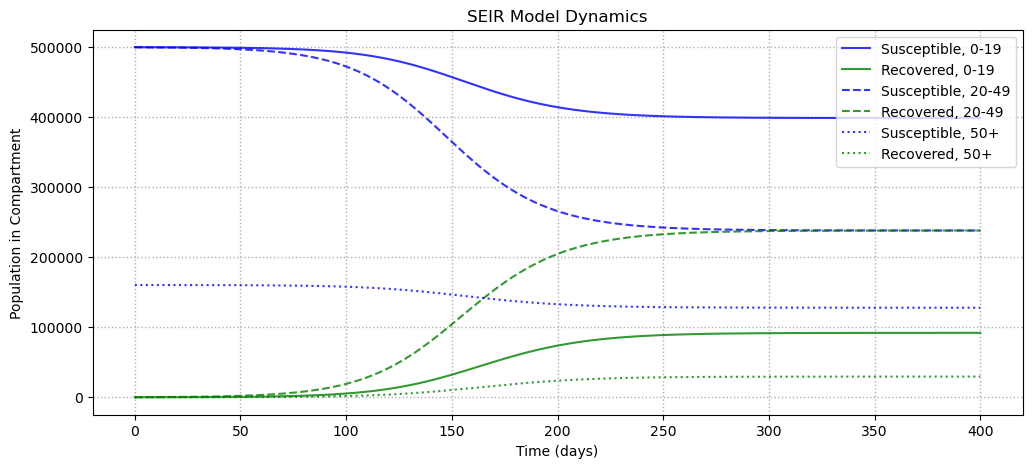

In [283]:
my_SEIRD.plot_Y_t(t,Y_matrix_0, compartments_to_plot=[0,3])

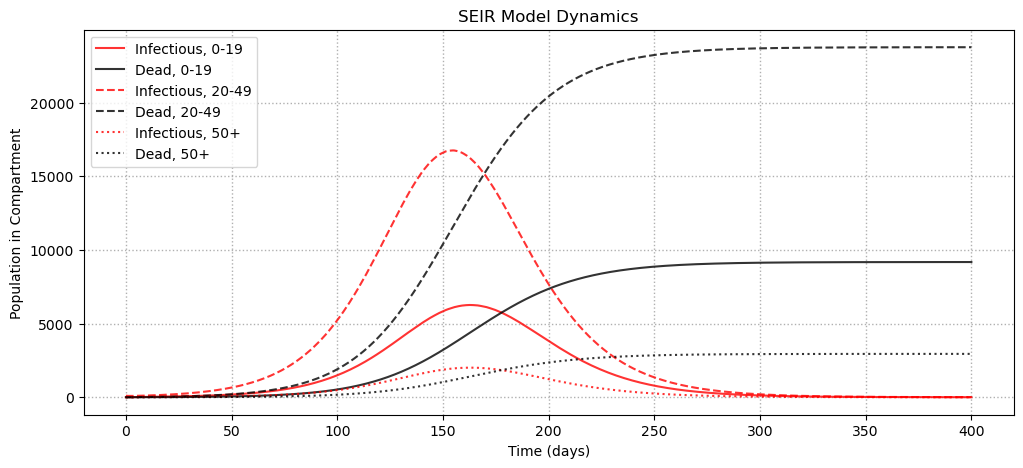

In [284]:
my_SEIRD.plot_Y_t(t,Y_matrix_0, compartments_to_plot=[2,4])

## Observations:

1) It seems that the only way of reducing the overall number of deaths in a category is to reduce the infectiousness $\beta$ for that compartment. If that happens, the overall number of dead in the limit of large $t$ is lower (although there is a larger number of susceptible left at the end).

2) If the coupling $\theta$ is very small, then having different infectivities $\beta$ for each environment is relevant. However, the larger $\theta$ is, the less different $\beta$ values matter. As expected, $\theta = 0$ gives completely decoupled populations, and $\theta = 0.5$ gives perfectly mixed populations. $\theta > 0.5$ has an interesting swapover, where the "old" population spend most of their time in a high$\beta$ environment, and thus actually die more.

3) It ultimately works on the idea that the disease dies out before the entire population is infected due to herd immunity. If the whole population gets infected, then the total number of deaths will be the same in the long run.

4) Theta does not need to be symmetric, i.e. the outcome when $\theta_{yo}$ and $\theta_{oy}$ are switched is not the same. Indeed if $\beta$ is not the same for both populations, then $\theta$ being switched changes the curves significantly. 

### Generating data for fitting

Generate some sparse data with a little noise. This is for fitting tests later.

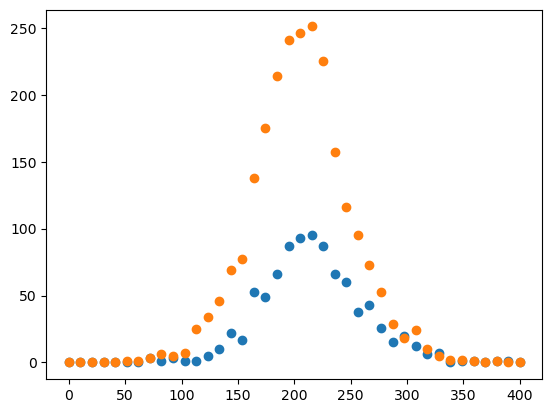

In [285]:
t_sparse = np.linspace(0,400, 40)

deaths_per_day = my_SEIRD.compute_derivs_per_day(t_sparse,
                           50,
                           Y_matrix_0)[:,4,:]

from numpy.random import poisson

shifted_fake_deaths_per_day = poisson(deaths_per_day)
#shifted_fake_deaths_per_day = deaths_per_day

plt.scatter(t_sparse, shifted_fake_deaths_per_day[0], label='Sparse Young Deaths per Day')
plt.scatter(t_sparse, shifted_fake_deaths_per_day[1], label='Sparse Old Deaths per Day')

# 2D version fitting

Going to generate data from the 2D version and fit that. 

In [450]:
import SEIRD_fitting
importlib.reload(SEIRD_fitting)

<module 'SEIRD_fitting' from '/home/gavin/Documents/NZ_data/SEIRD_fitting.py'>

Initial guesses for the fit

In [444]:
# Day of the first infection
day_of_start_0 = 48
# The distribution of the population across compartments and groups on the first day of infection.
Y_day_0_of_infection = Y_matrix_0 
# Transmission coefficients for each mixing environment
beta_vector_0 = np.array([0.11, 0.3])
# Recovery rate and death rate
gamma_0 = 0.15
delta_0 = gamma_0*0.1*np.array([1.,1.,2.])
# the coupling matrix between the boxes. 
theta_yo_0 , theta_oy_0 = 0.93 , 0.23
# The mean length of time between exposure and infectiousness
latent_period = latent_period #1.4
# the coupling matrix between the boxes. 
theta_matrix_0 = fitting_deaths.build_theta_matrix(theta_yo_0, theta_oy_0)

print("Initial guesses for the SEIRD model parameters:\n")
print("Day of start of infection = {}\n".format(day_of_start_0))
print(" Starting vector = \n",Y_day_0_of_infection)
print("\nParameters:\n beta_vector = ",beta_vector_0)
print(" gamma = {},\n delta = {},\n".format(gamma_0, delta_0))
print(" latent period = {},\n".format(latent_period))
print(" theta_matrix = \n",theta_matrix_0)

Initial guesses for the SEIRD model parameters:

Day of start of infection = 48

 Starting vector = 
 [[499000      0      0      0      0]
 [499000      0    100      0      0]
 [160000      0      0      0      0]]

Parameters:
 beta_vector =  [0.11 0.3 ]
 gamma = 0.15,
 delta = [0.015 0.015 0.03 ],

 latent period = [1.4 1.4 1.4],

 theta_matrix = 
 [[0.93 0.23 0.93]
 [0.07 0.77 0.07]]


Plot of the initial guess for the fit

Now trying to fit properly

In [445]:
y_data = shifted_fake_deaths_per_day
sigma_y = np.maximum(np.ones(shifted_fake_deaths_per_day.shape), np.sqrt(shifted_fake_deaths_per_day))

bounds = [(30, 70),
          (0.0, 1.0),
          (0.0, 1.0),
          (0.01, 1.0),
#          (0.0001, 0.1),
          (0.0, 1.0),
          (0.0, 1.0)]


In [451]:
my_model = SEIRD_model.SEIRD_model(beta_vector_0, gamma_0, delta_0, latent_period, theta_matrix_0)

In [452]:
my_fit = SEIRD_fitting.fitting_deaths(t_sparse,
                        y_data,
                        sigma_y=sigma_y,
                        seird_model=my_model,
                        bounds=bounds,
                        Y_0=Y_day_0_of_infection,
                       day_zero=day_of_start_0)


In [453]:
my_fit.fitting_params

[48,
 np.float64(0.11),
 np.float64(0.3),
 0.15,
 np.float64(0.93),
 np.float64(0.23)]

Xi value = 10.08989446329773


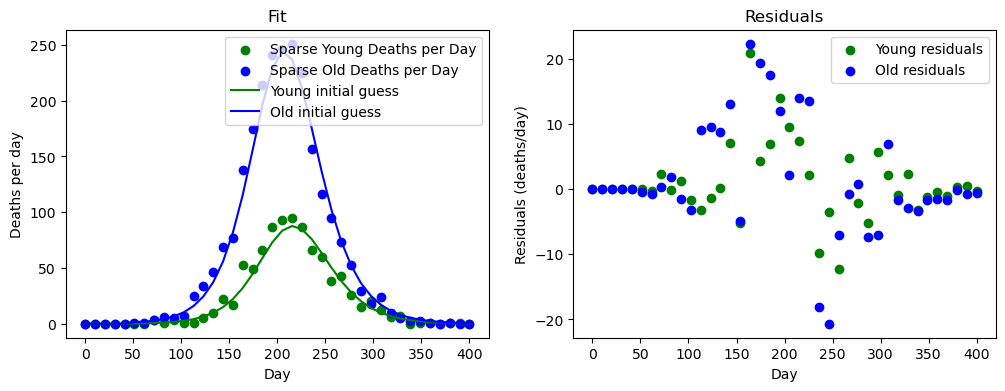

In [454]:
my_fit.plot_fit()

In [458]:
%%time

my_fit.do_minimize()
print(my_fit.opt)

CPU times: user 1min 5s, sys: 25.2 ms, total: 1min 5s
Wall time: 1min 6s


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7.691861418033744
             x: [ 5.122e+01  7.732e-02  3.413e-01  1.428e-01  9.527e-01
                  3.519e-01]
           nit: 835
          nfev: 1480
 final_simplex: (array([[ 5.122e+01,  7.732e-02, ...,  9.527e-01,
                         3.519e-01],
                       [ 5.122e+01,  7.732e-02, ...,  9.527e-01,
                         3.519e-01],
                       ...,
                       [ 5.122e+01,  7.732e-02, ...,  9.527e-01,
                         3.519e-01],
                       [ 5.122e+01,  7.732e-02, ...,  9.527e-01,
                         3.519e-01]], shape=(7, 6)), array([ 7.692e+00,  7.692e+00,  7.692e+00,  7.692e+00,
                        7.692e+00,  7.692e+00,  7.692e+00]))

In [456]:
my_fit.fitting_params

array([51.28205128,  0.08616891,  0.32710942,  0.14330294,  0.96097086,
        0.33176904])

In [459]:
my_fit.fitting_params

array([51.2205436 ,  0.07731647,  0.34128673,  0.14278654,  0.95270418,
        0.35194522])

Xi value = 7.691861418033755


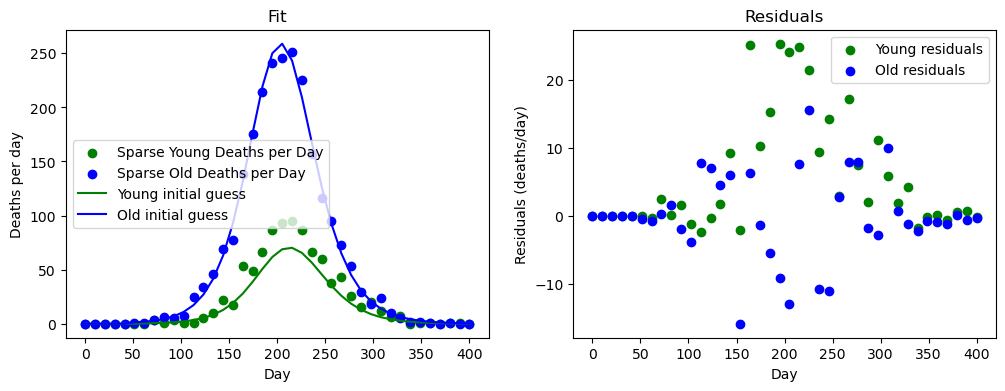

In [460]:
my_fit.plot_fit()

In [438]:
day_of_first_infection_fit, beta_fit_young, beta_fit_old, theta_yo_fit, theta_oy_fit, gamma_fit = my_fit.opt.x
delta_fit = gamma_fit * 0.01 * np.array([1.,1.,2])
print("Final fitted parameters are:")
print("   day zero = {:.2g} ,".format(day_of_first_infection_fit))
print("   beta_y   = {:.3g} ,".format(beta_fit_young))
#print("   beta_m   = {:.3g} ,".format(beta_fit_mid))
print("   beta_o   = {:.3g} ,".format(beta_fit_old))
print("   gamma    = {:.3g} ,".format(gamma_fit)) 
print("   delta    = {:.3g} ,".format(delta_fit[0]))
print("   theta_yo = {:.3g} ,".format(theta_yo_fit))
print("   theta_oy = {:.3g} ,\n".format(theta_oy_fit))

Final fitted parameters are:
   day zero = 70 ,
   beta_y   = 0 ,
   beta_o   = 1 ,
   gamma    = 0 ,
   delta    = 0 ,
   theta_yo = 1 ,
   theta_oy = 1 ,



Fit vs original data

# Training the model

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.

But, for starters, we'll just train the simple SIRD model on NZ data. 



In [63]:
NZ_death_data = pd.read_csv('deaths_by_age_and_date.csv').drop(columns=['Unnamed: 0'])
NZ_death_data.loc[:,'Total'] = NZ_death_data.loc[:,'0-19']+NZ_death_data.loc[:,'20-49']+NZ_death_data.loc[:,'50+']
NZ_death_data

,date_death,military_binary,0-19,20-49,50+,Total
0,1918-09-01 00:00:00,Y,0,1,0,1
1,1918-09-02 00:00:00,Y,0,6,0,6
2,1918-09-03 00:00:00,Y,0,4,0,4
3,1918-09-04 00:00:00,Y,0,23,0,23
4,1918-09-05 00:00:00,Y,1,15,0,16
...,...,...,...,...,...,...
147,1919-02-22 00:00:00,Y,0,2,0,2
148,1919-02-23 00:00:00,Y,0,1,0,1
149,1919-02-24 00:00:00,Y,0,2,0,2
150,1919-02-25 00:00:00,Y,0,3,0,3


In [64]:
N_0_19 , N_20_49, N_50p =  455502, 481145, 161536  # from age census data 1916
N_T = N_0_19 + N_20_49 + N_50p
print("From NZ census data 1916\n----------------------------\nNumber of 0 - 19:  {} ,\nNumber of 20 - 49: {} ,\nNumber of 50+:     {},\n     Total number :   {}".format(N_0_19, N_20_49, N_50p, N_T))

From NZ census data 1916
----------------------------
Number of 0 - 19:  455502 ,
Number of 20 - 49: 481145 ,
Number of 50+:     161536,
     Total number :   1098183


In [81]:
dummy = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
dummymin = min(dummy)
days_int_data = dummy.apply(lambda l: l - dummymin).dt.days

deaths_per_day_data = NZ_death_data.sort_values('date_death')['Total']

sigma = np.maximum(np.zeros(y.shape),np.sqrt(y))

# Fitting the matrix version

Text(0.5, 1.0, 'First Guess')

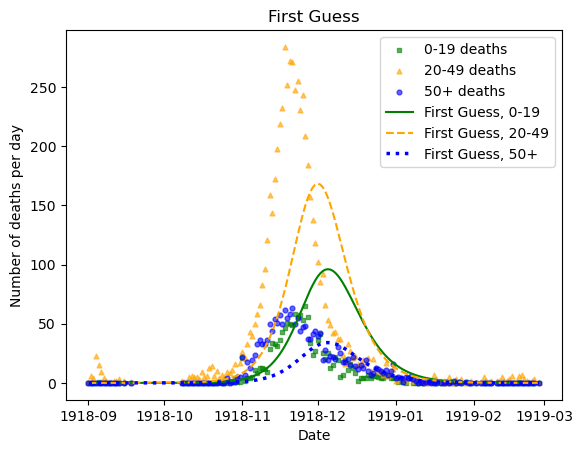

In [139]:
Y_day_0_of_infection = np.array([[455502-10, 0, 10, 0, 0],
                                 [481145-100, 0, 100, 0, 0],
                                 [161536-10, 0, 10, 0, 0]])

gamma_0, delta_0 = 0.3, 0.004

beta_vector_0 = [0.3, 0.7]

latent_period = 1.4

theta_yo_0, theta_oy_0 = 0.85, 0.15
theta_matrix_0 = build_theta_matrix( theta_yo_0, theta_oy_0)

day_of_first_infection_0 = 30

initial_guess_derivs = compute_derivs_per_day(days_int_data,
                           day_of_first_infection_0,
                           Y_day_0_of_infection,
                           beta_vector_0,
                           gamma_0,
                           delta_0,
                           latent_period,
                           theta_matrix_0)

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
y_young = NZ_death_data.sort_values('date_death')['0-19']
y_mid   = NZ_death_data.sort_values('date_death')['20-49']
y_old   = NZ_death_data.sort_values('date_death')['50+']
plt.scatter(xplot, y_young, color='green', label='0-19 deaths', alpha=0.6, s=12, marker='s')
plt.scatter(xplot, y_mid, color='orange', label='20-49 deaths', alpha=0.6, s=12, marker='^')
plt.scatter(xplot, y_old, color='blue', label='50+ deaths', alpha=0.6, s=12)

S_plot, E_plot, I_plot, R_plot, D_plot = initial_guess_derivs[0]
plt.plot(xplot, D_plot, 'g-', label='First Guess, 0-19', zorder=10)
S_plot, E_plot, I_plot, R_plot, D_plot = initial_guess_derivs[1]
plt.plot(xplot, D_plot, color='orange', label='First Guess, 20-49',zorder=11, linestyle='dashed')
S_plot, E_plot, I_plot, R_plot, D_plot = initial_guess_derivs[2]
plt.plot(xplot, D_plot, color='blue',label='First Guess, 50+',zorder=12, linestyle='dotted', linewidth=2.5)
plt.legend()
plt.xlabel('Date'), plt.ylabel('Number of deaths per day')
plt.title('First Guess')
#my_plotting_derivs.shape

In [140]:
y_data = np.array([y_young, y_mid, y_old])

sigma_data = np.maximum(np.ones(y_data.shape),np.sqrt(y_data))


In [141]:
from scipy.optimize import minimize

init_params = [day_of_start_0, *beta_vector_0, theta_yo_0, theta_oy_0]

opt = minimize(error_function, 
               init_params,
               args = (days_int_data, y_data, sigma_data, gamma_0, delta_0, latent_period, Y_day_0_of_infection),
               bounds=[(15,80),(0.1,1.5),(0.1,1.5),(0.1,0.9),(0.1,0.9)],
               tol=1e-12,
               method='Nelder-Mead',
               options={'maxiter':3000})
opt

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3587.7281360717507
             x: [ 1.828e+01  1.000e-01  7.687e-01  9.000e-01  1.000e-01]
           nit: 312
          nfev: 666
 final_simplex: (array([[ 1.828e+01,  1.000e-01, ...,  9.000e-01,
                         1.000e-01],
                       [ 1.828e+01,  1.000e-01, ...,  9.000e-01,
                         1.000e-01],
                       ...,
                       [ 1.828e+01,  1.000e-01, ...,  9.000e-01,
                         1.000e-01],
                       [ 1.828e+01,  1.000e-01, ...,  9.000e-01,
                         1.000e-01]], shape=(6, 5)), array([ 3.588e+03,  3.588e+03,  3.588e+03,  3.588e+03,
                        3.588e+03,  3.588e+03]))

In [142]:
day_of_first_infection_fit, beta_fit_1, beta_fit_2, theta_yo_fit, theta_oy_fit = opt.x
print("Final fitted parameters are:")
print("   day zero = {:.2g} ,".format(day_of_first_infection_fit))
print("   beta_1   = {:.3g} ,".format(beta_fit_1))
print("   beta_2   = {:.3g} ,".format(beta_fit_2))
print("   gamma    = {:.3g} ,".format(gamma_0)) 
print("   delta    = {:.3g} ,".format(delta_0))
print("   theta_yo = {:.3g} ,".format(theta_yo_fit))
print("   theta_oy = {:.3g} ,".format(theta_oy_fit))
print("        where the quoted uncertainty is 1 estimated standard deviation.\n")   

Final fitted parameters are:
   day zero = 18 ,
   beta_1   = 0.1 ,
   beta_2   = 0.769 ,
   gamma    = 0.3 ,
   delta    = 0.004 ,
   theta_yo = 0.9 ,
   theta_oy = 0.1 ,
        where the quoted uncertainty is 1 estimated standard deviation.



Text(0.5, 1.0, 'Fitted function')

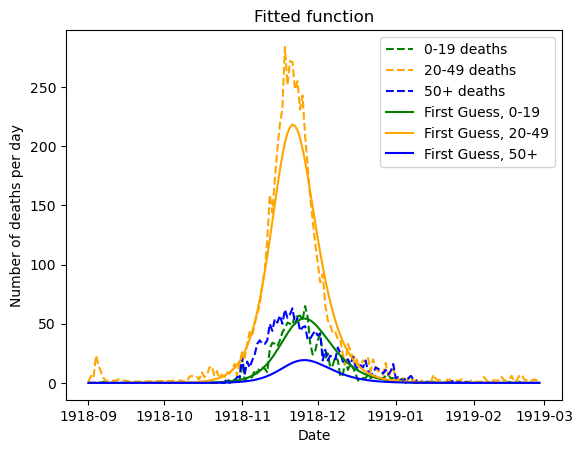

In [143]:
fitting_derivs = compute_derivs_per_day(days_int_data,
                           day_of_first_infection_fit,
                           Y_day_0_of_infection,
                           [beta_fit_1, beta_fit_2],
                           gamma_0,
                           delta_0,
                           latent_period,
                           build_theta_matrix(theta_yo_fit, theta_oy_fit))

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
y_young = NZ_death_data.sort_values('date_death')['0-19']
y_mid   = NZ_death_data.sort_values('date_death')['20-49']
y_old   = NZ_death_data.sort_values('date_death')['50+']
plt.plot(xplot, y_young, 'g--', label='0-19 deaths')
plt.plot(xplot, y_mid, '--', color='orange', label='20-49 deaths')
plt.plot(xplot, y_old, 'b--', label='50+ deaths')

S_plot, E_plot, I_plot, R_plot, D_plot = fitting_derivs[0]
plt.plot(xplot, D_plot, 'g-', label='First Guess, 0-19')
S_plot, E_plot, I_plot, R_plot, D_plot = fitting_derivs[1]
plt.plot(xplot, D_plot, color='orange', label='First Guess, 20-49')
S_plot, E_plot, I_plot, R_plot, D_plot = fitting_derivs[2]
plt.plot(xplot, D_plot, color='blue',label='First Guess, 50+')
plt.legend()
plt.xlabel('Date'), plt.ylabel('Number of deaths per day')
plt.title('Fitted function')